## Imports

In [49]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras import Model
from keras.regularizers import l2
from keras.optimizers import Adam, adamw_experimental
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import os

import matplotlib.pyplot as plt

## Generators

In [52]:
imageGeneration = ImageDataGenerator(
    rescale=1./255,
    
    # Applies image augmentation to reduce overfitting
    rotation_range=30,
    fill_mode='nearest',
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    shear_range=0.01,
    zoom_range=-0.01,
    brightness_range=[0.5, 1.5],
    )

In [53]:
trainGenerator = imageGeneration.flow_from_directory(
    'images/train',
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
)
validationGenerator = imageGeneration.flow_from_directory(
    'images/validation',
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Image Analysis

### Meant to show how the image augmentation affected the images

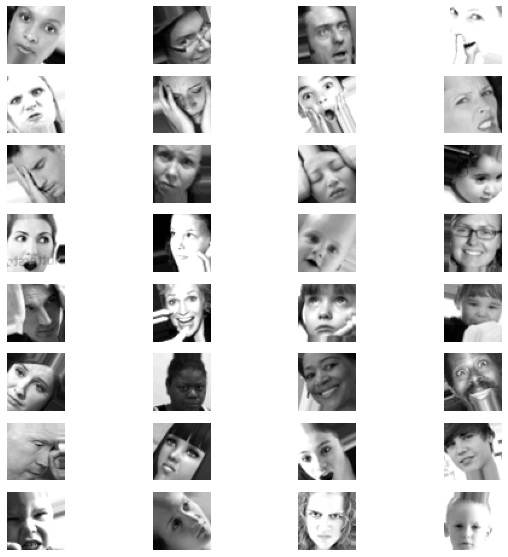

In [54]:
images, labels = next(trainGenerator)
fig, axs = plt.subplots(8, 4, figsize=(10, 10))

for i in range(32):
    ax = axs[i//4, i%4]
    ax.imshow(images[i, :, :, 0], cmap='gray')
    ax.axis('off')

plt.show()

In [55]:
trainGenerator.image_shape

(48, 48, 1)

In [56]:
validationGenerator.image_shape

(48, 48, 1)

## Model Building

In [57]:
emotionModel = Sequential()

# Layer 1
emotionModel.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(48, 48, 1)))
emotionModel.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
emotionModel.add(Conv2D(32, kernel_size=(1, 1), activation='relu'))
emotionModel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

## Applies Batch Normalisation for regulisation, further preventing overfitting   
emotionModel.add(BatchNormalization())
 
# Layer 2
emotionModel.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
emotionModel.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
emotionModel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
emotionModel.add(BatchNormalization())
 
# Layer 3
emotionModel.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
emotionModel.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
emotionModel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
emotionModel.add(BatchNormalization())

# layer 4
emotionModel.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
emotionModel.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
emotionModel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
emotionModel.add(BatchNormalization())

# Layer 5 - Final
emotionModel.add(Flatten())
emotionModel.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
emotionModel.add(Dropout(0.1))
emotionModel.add(Dense(7, activation='softmax'))

emotionModel.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

## Model Info

In [58]:
emotionModel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_34 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 conv2d_35 (Conv2D)          (None, 48, 48, 32)        1056      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_36 (Conv2D)          (None, 24, 24, 64)       

## Model Saving

In [59]:
try:
    os.mkdir('checkpoint')
except:
    pass

In [60]:
fileName = 'savedModel.h5'
checkpointDir = os.path.join('checkpoint', fileName)
callback = ModelCheckpoint(filepath = checkpointDir, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

## Model Run

In [61]:
# May take a couple hours

emotionalModelInfo = emotionModel.fit(
    trainGenerator,
    steps_per_epoch = len(trainGenerator),
    epochs = 50,
    validation_data = validationGenerator,  
    validation_steps= len(validationGenerator),
    callbacks=[callback]
)

Epoch 1/50
901/901 [==============================] - ETA: 0s - loss: 8.2937 - accuracy: 0.2412
Epoch 1: val_accuracy improved from -inf to 0.27073, saving model to checkpoint\savedModel.h5
901/901 [==============================] - 170s 187ms/step - loss: 8.2937 - accuracy: 0.2412 - val_loss: 6.7084 - val_accuracy: 0.2707
Epoch 2/50
901/901 [==============================] - ETA: 0s - loss: 5.3968 - accuracy: 0.2863
Epoch 2: val_accuracy improved from 0.27073 to 0.31857, saving model to checkpoint\savedModel.h5
901/901 [==============================] - 169s 188ms/step - loss: 5.3968 - accuracy: 0.2863 - val_loss: 4.2621 - val_accuracy: 0.3186
Epoch 3/50
901/901 [==============================] - ETA: 0s - loss: 3.5042 - accuracy: 0.3409
Epoch 3: val_accuracy improved from 0.31857 to 0.36046, saving model to checkpoint\savedModel.h5
901/901 [==============================] - 156s 173ms/step - loss: 3.5042 - accuracy: 0.3409 - val_loss: 2.9222 - val_accuracy: 0.3605
Epoch 4/50
901/901 

In [62]:
modelJson = emotionModel.to_json()
with open('emotionModel.json', 'w') as jsonFile:
    jsonFile.write(modelJson)